In [ ]:
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

# Load API key from .env file
_ = load_dotenv(find_dotenv())
api_key = os.environ["OPENAI_API_KEY"]

# Initialize client
client = OpenAI(api_key=api_key)

# Define your model
llm_model = "gpt-4o"  # or "gpt-3.5-turbo"

# Define function to call chat completion
def get_completion(prompt, model=llm_model):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message.content

# Example usage
print(get_completion("What is learning?"))

In [5]:
import torch
import clip
from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess the image
image = preprocess(Image.open("../img/eva-coffee.png")).unsqueeze(0).to(device)

# Define text descriptions
texts = ["eva coffee", "coffee break", "break"]
text_tokens = clip.tokenize(texts).to(device)

# Compute image and text features
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_tokens)

    # Calculate similarity
    logits_per_image, _ = model(image, text_tokens)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# Display results
for text, prob in zip(texts, probs[0]):
    print(f"{text}: {prob:.4f}")

eva coffee: 0.4219
coffee break: 0.5673
break: 0.0108


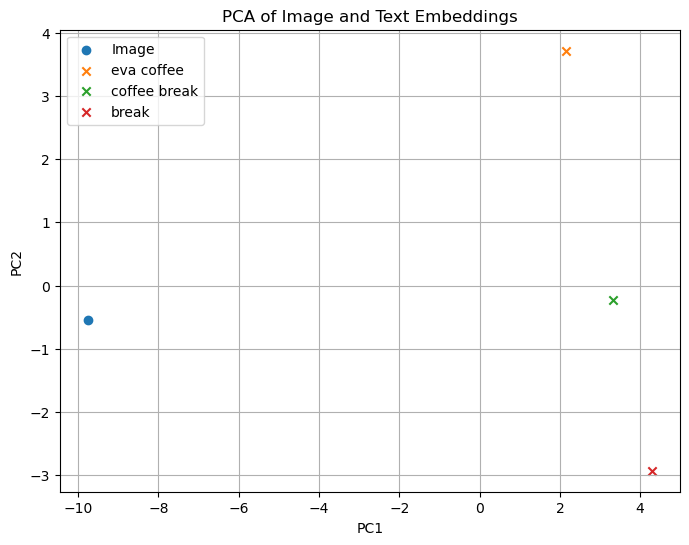

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Combine features
features = torch.cat([image_features, text_features], dim=0).cpu().numpy()

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[0, 0], pca_result[0, 1], label="Image", marker='o')
for i, text in enumerate(texts):
    plt.scatter(pca_result[i+1, 0], pca_result[i+1, 1], label=text, marker='x')
plt.legend()
plt.title("PCA of Image and Text Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

# Load the webpage
loader = WebBaseLoader("https://ubc-mds.github.io/policies/")
docs = loader.load()

```pip install langchain-community```
```pip install openai```
```pip install chromadb```

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Split the document into chunks
documents = text_splitter.split_documents(docs)

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

# Initialize the embeddings model
embedding_model = OpenAIEmbeddings()

# Create a vector store from the document chunks
vectorstore = Chroma.from_documents(documents, embedding=embedding_model)

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

# Initialize the language model
llm = ChatOpenAI(model="gpt-4", temperature=0)

# Create a retriever from the vector store
retriever = vectorstore.as_retriever()

# Set up the RetrievalQA chain
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

In [ ]:
# Example question
query = "What is the policy on academic integrity in the MDS program?"

# Get the answer
answer = qa_chain.run(query)

# Print the answer
print(answer)